In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
//hide this

<IPython.core.display.Javascript object>

In [2]:
#  hide this

%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from helper_functions import *

set_notebook_preferences()

## Bayesian linear regression

We have seen [previously](regression_regularisation.ipynb) how i) regularisation can be intrepreted in terms of a probabilistic prior over the regression weights, and ii) how MAP estimation of the weights mitigates some of the effects of overfitting. However, the approaches we have considered so far have not returned uncertainty estimates in the weights. Uncertainty estimates are key when, for example, making decisions and performing online incremental updates to the model. 

In this section we will consider Bayesian approaches to regression that return uncertainty in parameter estimates. The probabilisitc approach involves two phases. First we explicitly define our assumptions about how the data and parameters are generated. This is called the probabilistic model. Second, we use the rules of probability to manipulate the probabilistic model to perform the inferences we wish to make. Let's walk through these two steps in detail.


### 1. Probabilistic model

First we describe the probabilisitc model. You can think of this as a probabilistic recipe (or probabilistic program) for sampling datasets together with their underlying parameters. This recipe should encode knowledge about what we believe a typical dataset might look like before observing data. 

In the current case the probabilistic programme samples the regression weights from a Gaussian, forms the regression function, samples $N$ input locations and then samples $N$ outputs. (We have assumed the observation noise $\sigma_y^2$ and prior variance on the weights $\sigma_{\mathbf{w}}^2$ are known).

1. sample the weights $\mathbf{w}^{(m)} \sim \mathcal{N}(\mathbf{0},\sigma_{\mathbf{w}}^2 \mathrm{I})$ for $m=1...M$ 

2. define the regression function $f_{\mathbf{w}}^{(m)}(\mathbf{x})=\boldsymbol{\phi}(\mathbf{x})^\top \mathbf{w}^{(m)}$

3. sample $N$ input locations $\mathbf{x}^{(m)}_n \sim p(\mathbf{x})$ for $n=1...N$

4. sample $N$ output locations $y_n |\mathbf{w}^{(m)},\mathbf{x}^{(m)}_n,\sigma_{y}^2  \sim \mathcal{N}(f^{(m)}_{\mathbf{w}}(\mathbf{x}^{(m)}_n),\sigma_{y}^2)$ for $n=1...N$

Here are four datasets produced from this probabilistic model using linear basis functions and scalar inputs:

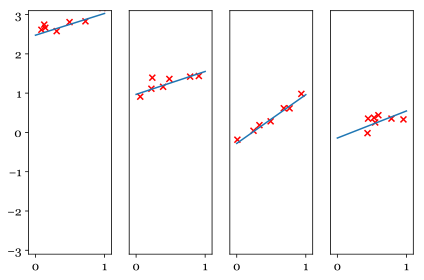

In [7]:
D = 1 # order of polynomial
M = 4 # number of samples of model
N = 7 # number of data points per model

var_w = 1 # a priori variance of weights
var_y = 0.01 # observation noise variance

# input locations
xs = np.linspace(0, 1, 100) # 100 points equispaced between 0 and 1

# polynomial basis functions
phi_pred = np.array([[x_ ** d for d in range(D + 1)] for x_ in xs]) 


# Gaussian basis functions
# var_phi = 0.05;
# phi_pred = np.array( [[ np.exp(-1/(2*var_phi)*np.power(x_-d/D,2))  for d in range(D + 1) ]  for x_ in xs]) 
# phi_samp = np.array( [[ np.exp(-1/(2*var_phi)*np.power(x_-d/D,2))  for d in range(D + 1) ]  for x_ in x_samp])

for m in range(1, M+1):
    
    # input locations
    x_samp = np.random.uniform(0, 1, N) 

    # polynomial basis functions
    phi_samp = np.array([[x_ ** d for d in range(D + 1)] for x_ in x_samp]) 


    
    # sample weights
    w = np.random.normal(0, np.power(var_w, 0.5), D+1)

    # plot function at input locations
    fs = phi_pred.dot(w) # output of the model at the points above
    
    y_samp = phi_samp.dot(w) + np.random.normal(0, np.power(var_y, 0.5), N)
    
    plt.subplot(1,M,m)
    plt.plot(xs, fs) # plot predictions
    plt.scatter(x_samp, y_samp, marker = 'x', color = 'red') # plot predictions
   
    plt.xlim([-0.1, 1.1])
    plt.ylim([-3.1, 3.1])
    if m  is not 1:
        remove_axes('y')
    
plt.tight_layout()
plt.show()

The probabilistic model is a joint distribution over all of the random variables: 
\begin{align}
p(\mathbf{w},\mathbf{y},\mathbf{X} | \sigma_{\mathbf{w}}^2,\sigma_{y}^2) & = p(\mathbf{w}| \sigma_{\mathbf{w}}^2)  p(\mathbf{X}) p(\mathbf{y}|\mathbf{X},\sigma_{y}^2) = p(\mathbf{w} | \sigma_{\mathbf{w}}^2) \prod_{n=1}^N p(x_n) p(y_n |\mathbf{w},\mathbf{x}_n,\sigma_{y}^2)\\
& = \mathcal{N}(\mathbf{w} ; \mathbf{0},\sigma_{\mathbf{w}}^2 \mathrm{I}) \prod_{n=1}^N p(\mathbf{x}_n) \mathcal{N}(y_n; f^{(m)}_{\mathbf{w}}(\mathbf{x}),\sigma_{y}^2)
\end{align}

All aspects of this model can be critiqued:

The assumption of **independent Gaussian observation noise** can be appropriate, e.g. if there are many independent noise sources and the central limit theorem has kicked in, and it leads to analytic inference. However, it may be inappropriate if the output noise is correlated or if there are outliers in the data (e.g. see [question 1B](regression_linear.ipynb) and [question 2](regression_regularisation.ipynb)).

The **zero mean Gaussian prior over the weights** encodes the fact that _a priori_ we expect the weight values to take values within a few standard deviations $\sigma_{\mathbf{w}}$ of zero. We will see in a moment that the use of a Gaussian distribution leads to tractable inference schemes. However, other distributions might be appropriate depending on the circumstances. For example, you might have reason to suspect that only a small number of the features $\phi_d(\mathbf{x})$ affect the output, in which case distributions that put more probability mass at zero and in the tails than a Gaussian might be more appropriate. Such distributions are called sparse distribtions and examples include the [Laplace](https://en.wikipedia.org/wiki/Laplace_distribution) and [Student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution). 

Notice here that our probabilistic model includes a **distribution over the input locations** are sampled. This is required to sample datasets, but it is not something that we encountered when we [interpreted regularisation in terms of MAP inference in a probabilistic model](regression_regularisation.ipynb). We will see that the distribution over the inputs does not affect the inference for the weights. This is why we have not specified a distributional family for $p(x)$.

### 2.1 Probabilistic inference for the weights

Now let's perform probabilistic inference for the weights. This involves computing the probability of the weights given the observed inputs and outputs $p(\mathbf{w}|\mathbf{y}, \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_{y}^2)$, or for shorthand the posterior distribution of the weights. 

Applying the product rule to the probabilistic model we find that the posterior can be computed by multiplying the prior $p(\mathbf{w}| \sigma_{\mathbf{w}}^2)$ (what we knew about the parameters before seeing data) with the likelihood of the parameters $p(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma_y^2)$ (what the data tell us about the parameters), and renormalising to ensure the density integrates to 1:

\begin{align}
p(\mathbf{w}|\mathbf{y}, \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_{y}^2)  \propto p(\mathbf{w}| \sigma_{\mathbf{w}}^2)  p(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma_y^2)
\end{align}

<details>
<summary>Detailed derivation for the posterior over the weights</summary>
    
    
Starting from the posterior distribution, $p(\mathbf{w}|\mathbf{y}, \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_{y}^2)$. we first apply the product rule,

\begin{align}
p(\mathbf{w}|\mathbf{y}, \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_{y}^2) = 
 \frac{1}{
 p(\mathbf{y}, \mathbf{X}| \sigma_{\mathbf{w}}^2, \sigma_{y}^2)
 }
 p(\mathbf{w},\mathbf{y}, \mathbf{X}| \sigma_{\mathbf{w}}^2, \sigma_{y}^2).
\end{align}

Now substituing in the joint distribution specified by the probabilistic model yields

\begin{align}
p(\mathbf{w}|\mathbf{y}, \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_{y}^2) & =
 \frac{1}{
 p(\mathbf{y}, \mathbf{X}| \sigma_{\mathbf{w}}^2, \sigma_{y}^2)
 } 
  p(\mathbf{w}| \sigma_{\mathbf{w}}^2) p(\mathbf{X}) p(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma_y^2) 
  = 
  \frac{1}{
 p(\mathbf{y} | \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_{y}^2)
 } 
  p(\mathbf{w}| \sigma_{\mathbf{w}}^2)  p(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma_y^2) \\ 
  & \propto p(\mathbf{w}| \sigma_{\mathbf{w}}^2)  p(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma_y^2).
\end{align}

In the last line we have dropped the term that does not depend on the weights: this is a normalising constant that we can recompute later by ensuring the distribution integrates to one. 
<div>

</div>
</details>

The next step is to substitute the distributional forms for the prior and the likelihood. The prior is a Gaussian distribution over the weights. The likelihood  also takes a Gaussian form when viewed as a _function of the weights_:


$$\begin{align}
p(\mathbf{w}| \sigma_{\mathbf{w}}^2) &= \frac{1}{(2\pi \sigma_{\mathbf{w}}^2)^{D/2}}\text{exp}\big(-\frac{1}{2\sigma_w^2}\mathbf{w}^\top \mathbf{w}\big)\\
p(\mathbf{y}|\mathbf{X}, \mathbf{w}, \sigma_y^2) &= \frac{1}{(2\pi \sigma_y^2)^{N/2}}\text{exp}\big(-\frac{1}{2\sigma_y^2}(\mathbf{y} - \boldsymbol{\Phi}\mathbf{w})^\top (\mathbf{y} - \boldsymbol{\Phi}\mathbf{w})\big)
\end{align}$$

Since the product of two Gaussians yields another Gaussian function the posterior will also be a Gaussian distribution,

\begin{align}
p(\mathbf{w}|\mathbf{y}, \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_{y}^2) = \mathcal{N}(\mathbf{w}; \mathbf{\mu}_{\mathbf{w} | \mathbf{y}, \mathbf{X} },\Sigma_{\mathbf{w} | \mathbf{y}, \mathbf{X} }).
\end{align}

where 

\begin{align}
\Sigma_{\mathbf{w} | \mathbf{y}, \mathbf{X} } & = \left( \frac{1}{\sigma_y^2} \boldsymbol{\Phi}^\top \boldsymbol{\Phi} + \frac{1}{\sigma_{\mathbf{w}}^2} \mathrm{I} \right)^{-1} \;\;\; \text{and} \;\;\;
\mathbf{\mu}_{\mathbf{w} | \mathbf{y}, \mathbf{X} } =  \Sigma_{\mathbf{w} | \mathbf{y}, \mathbf{X} } \frac{1}{\sigma_y^2}  \boldsymbol{\Phi}^\top \mathbf{y}.
\end{align}


<details>
<summary>Detailed derivation for the posterior mean and covariance</summary>
 
<div>
In order to find the posterior mean and covariance, we i) multiply together the prior and likelihood and expand the result in terms of an exponentiated quadratic in $\mathbf{w}$,  and then ii) compare coefficients to identify the posterior mean and covariance.
     
Step (i): Multiplying prior and likelihood 

\begin{align}
p(\mathbf{w}|\mathbf{y}, \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_y^2) &\propto \text{exp}\big(-\frac{1}{2\sigma_y^2}(\mathbf{y} - \boldsymbol{\Phi}\mathbf{w})^\top (\mathbf{y} - \boldsymbol{\Phi}\mathbf{w}) -\frac{1}{2 \sigma_{\mathbf{w}}^2}\mathbf{w}^\top  \mathbf{w}  \big)\\
& \propto \text{exp}\left( - \frac{1}{2}\mathbf{w}^\top \left( \frac{1}{\sigma_y^2} \boldsymbol{\Phi}^\top \boldsymbol{\Phi} + \frac{1}{\sigma_{\mathbf{w}}^2} \mathrm{I} \right)\mathbf{w} + \frac{1}{\sigma_y^2} \mathbf{w}^\top \boldsymbol{\Phi}^\top \mathbf{y} \right) 
\end{align}


Step (ii): comparing coefficients to a Gaussian


\begin{align}
p(\mathbf{w}|\mathbf{y}, \mathbf{X}, \sigma_{\mathbf{w}}^2, \sigma_y^2) &= \mathcal{N}(\mathbf{w}; \mathbf{\mu}_{\mathbf{w} | \mathbf{y}, \mathbf{X} },\Sigma_{\mathbf{w} | \mathbf{y}, \mathbf{X} }), \\
& \propto \text{exp}\left( - \frac{1}{2}\mathbf{w}^\top \Sigma^{-1}_{\mathbf{w} | \mathbf{y}, \mathbf{X} }\mathbf{w} + \mathbf{w}^\top \Sigma^{-1}_{\mathbf{w} | \mathbf{y}, \mathbf{X} } \mathbf{\mu}_{\mathbf{w} | \mathbf{y}, \mathbf{X} } \right).
\end{align}

Hence the posterior covariance and mean are given by:

\begin{align}
\Sigma_{\mathbf{w} | \mathbf{y}, \mathbf{X} } & = \left( \frac{1}{\sigma_y^2} \boldsymbol{\Phi}^\top \boldsymbol{\Phi} + \frac{1}{\sigma_{\mathbf{w}}^2} \mathrm{I} \right)^{-1}, \;\;\;
\mathbf{\mu}_{\mathbf{w} | \mathbf{y}, \mathbf{X} } &=  \Sigma_{\mathbf{w} | \mathbf{y}, \mathbf{X} } \frac{1}{\sigma_y^2}  \boldsymbol{\Phi}^\top \mathbf{y}.
\end{align}

</div>
</details>

In a moment we will derive the probabilistic approach to prediction. Before we do this, let's take some time to consider the results above.

First, notice that the mean of the posterior distribution over the weights can be expressed as

$$
\mathbf{\mu}_{\mathbf{w} | \mathbf{y}, \mathbf{X} }  = (\sigma^{-2}\boldsymbol{\Phi}^\top \boldsymbol{\Phi} + \lambda \mathbf{I})\boldsymbol{\Phi}^\top \mathbf{y}
$$

where $\lambda = \sigma^2_\mathbf{w} / \sigma^2_y $. This recovers the solution from regularised least squares fitting which we previously interpreted as finding the _maximum a posteriori_ setting of the weights given the data,

\begin{align}
\mathbf{w}^{\text{MAP}} & = \underset{\mathbf{w}}{\mathrm{arg\,max}} \; p(\mathbf{w} | \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2).
\end{align}

This all adds up because the posterior is Gaussian and the most probable weight under a Gaussian is the mean value.

\begin{align}
\mathbf{w}^{\text{MAP}} & = \underset{\mathbf{w}}{\mathrm{arg\,max}} \; p(\mathbf{w} | \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) = \mathbf{\mu}_{\mathbf{w} | \mathbf{y}, \mathbf{X} } = \mathbb{E}_{p(\mathbf{w} | \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)}(\mathbf{w}).
\end{align}

Second, notice that the **prior** distribution and the **posterior** distribution belong to the same family (i.e. Gaussian). When a model has this property, the prior and likelihood are said to be **conjugate**, or for short it is said to have a **conjugate prior**. Conjugate priors lead to tractable and convenient analytic posterior distributions. 

### 2.2 Probabilistic inference for prediction

Now let's consider how to use probabilistic inference to make predictions for an unseen output $y^*$ at input location $\mathbf{x}^*$. The MAP and maximum likelihood methods use a point estimate for the weights, $\hat{\mathbf{w}}$, simply computing $p(y^* | \mathbf{x}^*, \hat{\mathbf{w}},\sigma_y^2,\sigma_{\mathbf{w}}^2$. This is equivalent to assuning that the weights are known to take the value $\hat{\mathbf{w}}$. The full probabilistic approach considers undertainty in $\mathbf{w}$ and is therefore more complex. The full solution is a probability distribution over the unseen output, give the input and the training data, $p(y^* | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)$, which can be computed by
$$
p(y^* | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) = \int p(y^* | \mathbf{x}^*, \mathbf{w},\sigma_y^2) p(\mathbf{w}|\mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) d\mathbf{w}.
$$

So, the predictive is formed by considering every possible setting of the underlying weights, computing the associated prediction $p(y^* | \mathbf{x}^*, \mathbf{w})$,  weighting this by the posterior probability of the weight taking that value $p(\mathbf{w}|\mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)$, and averaging these weighted predictions together. The form of the predictive distribution may seem intuitively obvious, but for a full derivation see below.

<details>
<summary>Detailed derivation for the predictive distribution</summary>
 
<div>
First we apply the sum rule to introduce the weight back into the expression. The sum rule states  $p(A|C) = \int p(A,B|C) \text{d}B$ and we use $A = y^* $, $B = \mathbf{w}$ and $C = \{x^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2\}$ so

\begin{align}
p(y^* | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)  = \int p(y^*,\mathbf{w} | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) \mathrm{d} \mathbf{w} 
\end{align}

Second we apply the product rule. The product rule states $p(A,B|C) = p(B|C)p(A|B,C)$ and we use the same variable associations as above to give

\begin{align}
p(y^* | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)  = \int p( \mathbf{w} | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) p(y^* | \mathbf{w} , \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) \mathrm{d} \mathbf{w} 
\end{align}

Third, we use the structure of the probabilistic model to simplify the above expression (more precisely the conditional independencies implied by the model). By themselves, the test inputs $\mathbf{x}^*$ provide no information about the weights $\mathbf{w}$ so $p( \mathbf{w} | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) = p( \mathbf{w} | \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)$. Moreover, if the weights $\mathbf{w}$ are known then the training data provide no additional useful information for prediction so $p(y^* | \mathbf{w} , \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) = p(y^* | \mathbf{w} , \mathbf{x}^*, \sigma_y^2,\sigma_{\mathbf{w}}^2)$. 

Together these simplifications yield the expression for the predictive,

\begin{align}
p(y^* | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)  = \int p( \mathbf{w} |  \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) p(y^* | \mathbf{w} , \mathbf{x}^*, \sigma_y^2,\sigma_{\mathbf{w}}^2) \mathrm{d} \mathbf{w}.
\end{align}

</div>
</details>

There are long winded ways of performing the integral over the weights required to compute the predictive. Fortunately there is one simple route to the solution that involves no integration at all. 

The posterior $p( \mathbf{w} |  \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)$ is Gaussian. The test ouputs are a linear transformation of the weights plus Gaussian noise. Since Gaussians are closed under linear transforms and under the addition of Gaussian noise, the predictive distribution will also be Gaussian,

\begin{align}
p(y^* | \mathbf{x}^*, \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2)  = \mathcal{N}(y^* ; \mu_{y^*|\mathbf{y},\mathbf{X}},\sigma^2_{y^*| \mathbf{y},\mathbf{X}}).
\end{align}

The expectation and variance of the predictive are then fairly simple to compute depending on the mean $\mu_{\mathbf{w}| \mathbf{y},\mathbf{X}}$ and covariance $\Sigma_{\mathbf{w}| \mathbf{y},\mathbf{X}}$ of the posterior distribution over the weights and the basis functions at the test locations $\boldsymbol{\phi}_*$,

\begin{align}
\mu_{y^*|\mathbf{y},\mathbf{X}} = \boldsymbol{\phi}_{\ast}^\top \mu_{\mathbf{w}| \mathbf{y},\mathbf{X}}\\
\sigma^2_{y^*| \mathbf{y},\mathbf{X}} = \boldsymbol{\phi}_*^\top \Sigma_{\mathbf{w}| \mathbf{y},\mathbf{X}} \boldsymbol{\phi}_*  + \sigma_{y}^2.
\end{align}

<details>
<summary>Detailed derivation for the mean and variance of the predictive distribution</summary>
 
<div>
In the following we lighten the notation by using the shorthand $\mathbb{E}_{p( \mathbf{w} |  \mathbf{y},\mathbf{X},\sigma_y^2,\sigma_{\mathbf{w}}^2) p(y^*|\mathbf{x}^*,\mathbf{w},\sigma_y^2)}[\cdot] = \mathbb{E}[\cdot]$. Therefore
    
\begin{align}
\mu_{y^*|\mathbf{y},\mathbf{X}} =  \mathbb{E}[y^*] &= \mathbb{E}[\boldsymbol{\phi}_*^\top \mathbf{w} + \epsilon] = \boldsymbol{\phi}_*^\top\mathbb{E}[\mathbf{w}] = \boldsymbol{\phi}_*^\top \mu_{\mathbf{w}| \mathbf{y},\mathbf{X}}\\
~\\
\sigma^2_{y^*| \mathbf{y},\mathbf{X}} = \mathbb{E}[(y^* - \mu_{y^*|\mathbf{y},\mathbf{X}})^2] &= \mathbb{E}[(\boldsymbol{\phi}_*^\top \mathbf{w} - \boldsymbol{\phi}_*^\top \mu_{\mathbf{w}| \mathbf{y},\mathbf{X}} + \epsilon)^2] = \mathbb{E}[(\boldsymbol{\phi}_*^\top (\mathbf{w} - {\mu}_{\mathbf{w}| \mathbf{y},\mathbf{X}}) + \epsilon)^2] \\
~\\
&= \boldsymbol{\phi}_*^\top \mathbb{E}[(\mathbf{w} - {\mu}_{\mathbf{w}| \mathbf{y},\mathbf{X}})(\mathbf{w} - {\mu}_{\mathbf{w}| \mathbf{y},\mathbf{X}})^\top] \boldsymbol{\phi}_*  + \sigma_y^2\\
~\\
&= \boldsymbol{\phi}_*^\top \Sigma_{\mathbf{w}| \mathbf{y},\mathbf{X}} \boldsymbol{\phi}_*  + \sigma_{y}^2
\end{align}

</div>
</details>

Let's implement these results on the linear and non-linear datasets.

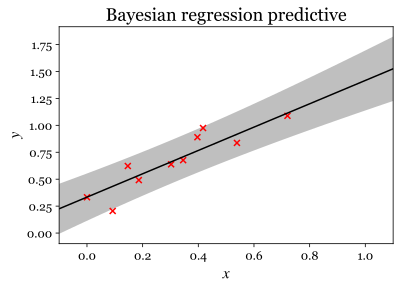

In [4]:
x_lin = np.load('reg_lin_x.npy')  
y_lin = np.load('reg_lin_y.npy') # loading the linear regression dataset into numpy arrays

lamda = 1
phi = np.array([[x_ ** d for d in range(0, 2)] for x_ in x_lin]) # X instantiated more elegantly here

prior_term = lamda * np.eye(2) # prior covariance matrix to include in MAP solution
w_maxlik = np.linalg.inv((phi.T).dot(phi) + prior_term).dot(phi.T).dot(y_lin) # MAP weights to use in mean(y*)
var = np.sum((y_lin - phi.dot(w_maxlik)) ** 2) / x_lin.shape[0] # maximum-likelihood variance to use in var(y*)

S = np.linalg.inv((phi.T).dot(phi) / var + lamda * np.eye(2)) # posterior distribution covariance matrix
mu = S.dot(phi.T).dot(y_lin) / var # posterior distribution mean vector

x_pred = np.linspace(-0.1, 1.1, 100)
X_pred = np.array([[x_ ** d for d in range(0, 2)] for x_ in x_pred])

mu_pred = X_pred.dot(mu) # calculate mean(y*)
stdev_pred = (np.sum(X_pred.dot(S) * X_pred, axis = 1) + var) ** 0.5 # calculate Var(y*)^0.5

plt.fill_between(x_pred, mu_pred + stdev_pred, mu_pred - stdev_pred, facecolor = 'grey', alpha = 0.5) # plot confidence intervals = +/- Var(y*)^0.5
plt.scatter(x_lin, y_lin, marker = 'x', color = 'red') # plot data
plt.plot(x_pred, mu_pred, color = 'black') # plot mean(y*)
beautify_plot({"title":"Bayesian regression predictive", "x":"$x$", "y": '$y$'})
plt.xlim([-0.1, 1.1])
plt.show()

The black line shows $\mathbb{E}[y^*]$, and the gray area shows $\pm \sqrt{\text{Var}(y^*)}$, i.e. plus/minus one standard deviation of the predictive distribution. The predictive uncertainty is a direct consequence in the uncertainty of $\mathbf{w}$ captured by the Bayesian approach. Uncertainty quantification is a great benefit of the bayesian approach because we can now justify our conclusions about the data in a principled way, unlike in the maximum-likelihood case where we only get an estimate for $y^*$ without a measure of how off this $y^*$ may be from the right answer. Let's apply this method to the non-linear dataset.

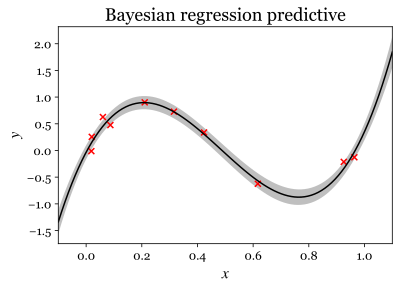

In [5]:
# exactly the same process with the linear case, except phi is different

x_nonlin = np.load('reg_nonlin_x.npy') 
y_nonlin = np.load('reg_nonlin_y.npy') # loading the non-linear dataset

lamda = 10 ** -5
D = 3
phi = np.array([[x_ ** d for d in range(0, D + 1)] for x_ in x_nonlin])

prior_term = lamda * np.eye(D + 1)
w_maxlik = np.linalg.inv((phi.T).dot(phi) + prior_term).dot(phi.T).dot(y_nonlin)
var = np.sum((y_nonlin - phi.dot(w_maxlik)) ** 2) / x_nonlin.shape[0]

S = np.linalg.inv((phi.T).dot(phi) / var + lamda * np.eye(D + 1))
mu = S.dot(phi.T).dot(y_nonlin) / var

x_pred = np.linspace(-0.1, 1.1, 100)
phi_pred = np.array([[x_ ** d for d in range(0, D + 1)] for x_ in x_pred])

mu_pred = phi_pred.dot(mu)
stdev_pred = (np.sum(phi_pred.dot(S) * phi_pred, axis = 1) + var) ** 0.5

plt.fill_between(x_pred, mu_pred + stdev_pred, mu_pred - stdev_pred,
                 facecolor = 'grey', alpha = 0.5)
plt.scatter(x_nonlin, y_nonlin, marker = 'x', color = 'red')
plt.plot(x_pred, mu_pred, color = 'black')
beautify_plot({"title":"Bayesian regression predictive", "x":"$x$", "y": '$y$'})
plt.xlim([-0.1, 1.1])
plt.show()

## Update learning and visualizations

Until now we have been considering the whole dataset in one go. In this section we will be exploring how each point of in the dataset affects our knowledge about the model. This will expand our intuition about the bayesian approach and also show how we may go about *online learning* $-$ that is learning where the datapoints are gradually made available in a sequence. Online learning would for example be useful for scenarios such as weather prediction, where one can use each day's new data to improve the weather model.

Consider this scenario: we start off with a prior $p(\mathbf{w})$ and the data is made available on a point-by-point basis, in $(x_n, y_n)$ pairs. After observing one point, we can use Bayes' rule to evaluate the posterior, and use this to calculate the predictive:

$$
p(\mathbf{w}| y_1, x_1) \propto p(y_1| x_1, \mathbf{w}, \sigma^2)p(\mathbf{w})
$$

$$
p(y^* | x^*, y_1, x_1) = \int p(y^* | x^*, \mathbf{w}) p(\mathbf{w}|y_1, x_1) d\mathbf{w}
$$

When $(x_2, y_2)$ becomes available, we can use it to update our model. The weight distribution prior to seeing $(x_2, y_2)$ is $p(\mathbf{w}|y_1, x_1)$, reflecting the knowledge gained from $(x_1, y_1)$. Applying Bayes' rule again:

$$
p(\mathbf{w}| \{y_{n}, x_{n}\}^2_{n = 1}) \propto p(y_2| x_2, \mathbf{w}, \sigma^2)p(\mathbf{w}|y_1, x_1)
$$

$$
p(y^* | x^*, \{y_{n}, x_{n}\}^2_{n = 1}) = \int p(y^* | x^*, \mathbf{w}) p(\mathbf{w}|\{y_{n}, x_{n}\}^2_{n = 1}) d\mathbf{w}
$$

And in general after observing $N$ datapoints:

$$
p(\mathbf{w}| \{y_{n}, x_{n}\}^{N}_{n = 1}) \propto p(y_{N}| x_{N}, \mathbf{w}, \sigma^2)p(\mathbf{w}|y_{N-1}, x_{N-1})
$$

$$
p(y^* | x^*, \{y_{n}, x_{n}\}^{N}_{n = 1}) = \int p(y^* | x^*, \mathbf{w}) p(\mathbf{w}|\{y_{n}, x_{n}\}^N_{n = 1}) d\mathbf{w}
$$

**Note how the posterior of the $\mathbf{(N-1)^{th}}$ step becomes the prior for the $\mathbf{N^{th}}$ step.** This reflects the gradual increase in our knowledge about $\mathbf{w}$. It should be pointed out that for arbitrary distributions we must calculate the constant of proportionality for the posterior, or equivalently normalize $p(y^* | x^*, \{y_{n}, x_{n}\}^{N}_{n = 1})$ at the end to get a valid probability distribution $-$ this integral may be challenging and will often need to be approximated. Fortunately, in the special case of gaussian likelihoods with a conjugate prior we don't need to bother with this since the normalization constant is determined by the covariance matrix which we already know how to find.

The last outstanding point regarding this process is the noise level \\(\sigma\\). When learning the whole dataset at once, we used the \\(\sigma_{ML}\\) which maximised the likelihood as an estimate for the noise magnitude. It is possible to follow a fully Bayesian approach including a prior over \\(\sigma\\), but this is too involved for our purposes, so we will stick with the estimate \\(\sigma_{ML}\\) which maximises the likelihood of the observed points. For the first step where no points have yet been observed \\(\sigma_{ML}\\) would be \\(0\\) giving an infinitely sharp gaussian. To prevent this problem, which would otherwise constrain subsequent posteriors to be infinitely sharp as well, we will use an arbitrary noise level of \\(1\\).

Let's implement this method for the linear dataset since this has $2$ weights which we can easily visualise with a contour plot $-$ unlike the non-linear example which has several weights which we can't easily visualise in one go. At each step, will also draw $3$ weight samples from the posterior and plot the corresponding lines in data-space.

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


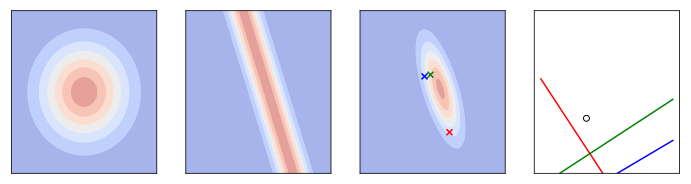

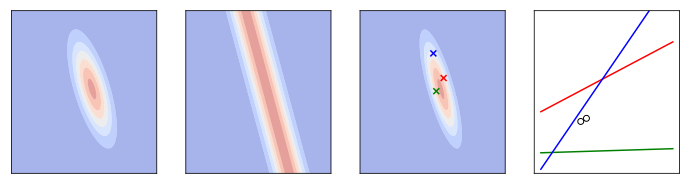

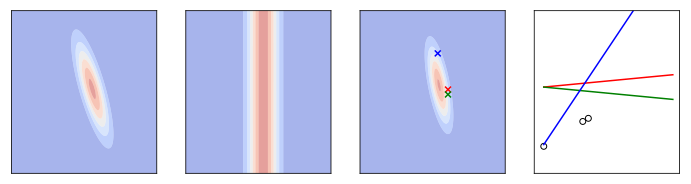

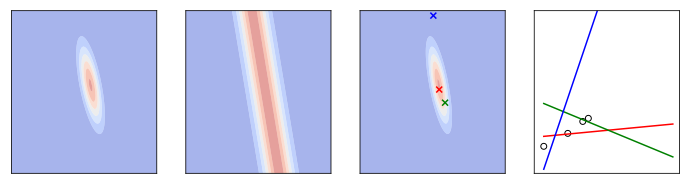

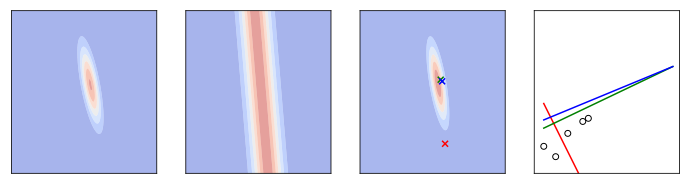

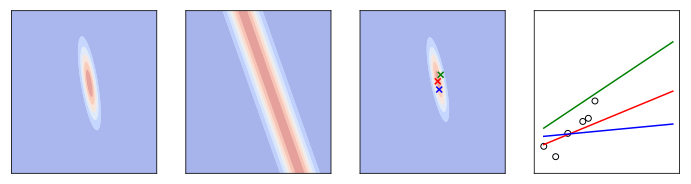

In [6]:
w1_range, w2_range = np.linspace(-5, 5, 100), np.linspace(-5, 5, 100) # specify the range of weights to be visualised
w1, w2 = np.meshgrid(w1_range, w2_range) # returns two 2d arrays with the values of w1_range and w2_range (see docs!)
grid = np.stack([w1, w2], axis = 2) # stack the two grids together to do aritmetic elegantly later

lamda = 4
no_points = 5 # do the algorithm for 3 sequential observations
prior = None # start with a null prior
noise = 1

colours = ['red', 'green', 'blue']
x_ = np.linspace(0, 1, 100)

for n in range(no_points + 1):

    X = np.array([[x_lin[n] ** d for d in range(0, 2)]]) # X contains a single point (x[n]) for online learning
    
    if n == 0:
        prior_Q = np.sum(grid.dot(np.eye(2) / lamda) * grid, axis = 2) # quadratic form of prior (goes in the exponent)
        prior = np.exp(-1 / 2 * prior_Q) # exponentiate quadratic form to get the prior
        
    lik_Q = np.sum((y_lin[n] - grid.dot(X.T)) ** 2/0.5, axis = 2) # quadratic form of likelihood of (x[n], y[n]) point
    lik = np.exp(-1 / 2 * lik_Q) # exponentiate quadratic form to get the likelihood of the new point
    
    post = prior * lik # posterior is prior*lik by Bayes' rule

    plt.figure(figsize = (12, 3)) # add new figure to plot this step
    for i, values in enumerate([prior, lik, post]):
        plt.subplot(1, 4, i + 1)
        plt.contourf(w1_range, w2_range, values, cmap = 'coolwarm', alpha = 0.5) # plot prior after n points
        remove_axes()
    
    for i in range(3):
        plt.subplot(143)
        w1, w2 = sample_weights_from(w2_range, w1_range, post)
        plt.scatter(w1, w2, marker = 'x', color = colours[i])
        
        plt.subplot(144)
        plt.plot(x_, w1 + w2 * x_, color = colours[i])
        remove_axes()
    
    plt.subplot(144)
    plt.scatter(x_lin[:n + 1], y_lin[:n + 1], marker = 'o', facecolor = 'None', edgecolor = 'black')
    plt.ylim([0, 2])
    
    prior = post.copy() # set prior of the next step to be the posterior of the current step

    plt.show()

The first plot in the first row we see the prior before any data has been observed. After one datapoint is observed, our certainty about the values of the weights is improved: the likelihood (second plot, first row) multiplied by the prior gives a narrowed posterior (third plot, first row). Three independent weight samples are drawn (red, green and blue crosses) from the posterior giving the corresponding linear trendlines in data space (data as black crosses). In the next step **the prior is the posterior of the previous step**, i.e. $3^{rd}$ plot of $n^{th}$ row is the same as the $1^{st}$ plot of the $(n+1)^{th}$ row. Note that as more datapoints are added the posterior narrows down, and the weights are constrained to a progressively narrower area. This is reflected in the data space where the red/green/blue lines are also progressively constrained.



There is still one missing piece, namely the value of $\sigma^{-2}$. We can estimate this by calculating the value of $\sigma^{2}$ which maximizes the log-likelihood $\mathcal{L}$:

$$\begin{align}
\frac{\partial\mathcal{L}}{\partial \sigma^{-2}} = -\frac{N}{2\sigma^2} -\frac{1}{2}(\mathbf{y} - \boldsymbol{\Phi}\mathbf{w})^\top (\mathbf{y} - \boldsymbol{\Phi}\mathbf{w}) = 0\\
~\\
\implies \sigma^{2} = \frac{1}{N}(\mathbf{y} - \boldsymbol{\Phi}\mathbf{w})^\top (\mathbf{y} - \boldsymbol{\Phi}\mathbf{w})
\end{align}$$

Having covered bayesian linear regression, you should now understand:

1. Why finding the $\mathbf{w}$ using MAP with a gaussian likelihood and prior is equivalent to doing least-squares with $\mathbf{L2}$ regularization
2. How to take a bayesian inference approach to regression problems, including how to calculate $\mathbb{E}$(y) and Var(y) for your fitted model.
3. How the model can be adapted to dynamically change with new data points for online learning
